In [3]:
import os 
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import requests
import cv2 
from numpy.polynomial import Polynomial
from skimage.morphology import skeletonize, binary_closing, square, binary_erosion, binary_dilation, medial_axis, thin, disk, convex_hull_image, diamond, star, isotropic_closing, remove_small_objects
from skimage.filters import threshold_otsu
import json

In [4]:
def plot_image(img):
    plt.figure(figsize=(20,10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [5]:
def is_valid_intersection(neighbourhood_patch) : 
    # A list of valid intersections             
    # These are in the format (clockwise order)
    # 2 3 4
    # 1 C 5
    # 8 7 6 
    validIntersection = [[0,1,0,1,0,0,1,0],[0,0,1,0,1,0,0,1],[1,0,0,1,0,1,0,0],
                         [0,1,0,0,1,0,1,0],[0,0,1,0,0,1,0,1],[1,0,0,1,0,0,1,0],
                         [0,1,0,0,1,0,0,1],[1,0,1,0,0,1,0,0],[0,1,0,0,0,1,0,1],
                         [0,1,0,1,0,0,0,1],[0,1,0,1,0,1,0,0],[0,0,0,1,0,1,0,1],
                         [1,0,1,0,0,0,1,0],[1,0,1,0,1,0,0,0],[0,0,1,0,1,0,1,0],
                         [1,0,0,0,1,0,1,0],[1,0,0,1,1,1,0,0],[0,0,1,0,0,1,1,1],
                         [1,1,0,0,1,0,0,1],[0,1,1,1,0,0,1,0],[1,0,1,1,0,0,1,0],
                         [1,0,1,0,0,1,1,0],[1,0,1,1,0,1,1,0],[0,1,1,0,1,0,1,1],
                         [1,1,0,1,1,0,1,0],[1,1,0,0,1,0,1,0],[0,1,1,0,1,0,1,0],
                         [0,0,1,0,1,0,1,1],[1,0,0,1,1,0,1,0],[1,0,1,0,1,1,0,1],
                         [1,0,1,0,1,1,0,0],[1,0,1,0,1,0,0,1],[0,1,0,0,1,0,1,1],
                         [0,1,1,0,1,0,0,1],[1,1,0,1,0,0,1,0],[0,1,0,1,1,0,1,0],
                         [0,0,1,0,1,1,0,1],[1,0,1,0,0,1,0,1],[1,0,0,1,0,1,1,0],
                         [1,0,1,1,0,1,0,0]]
    
    if neighbourhood_patch in validIntersection : 
        return True
    else : 
        return False

In [6]:
def get_skeleton_intersection(skeleton):
    """ Given a skeletonised image, it will give the coordinates of the intersections of the skeleton"""
    print("Getting intersections in skeleton (more than 2 neighbours)")
    skeleton_gray = cv2.cvtColor(skeleton, cv2.COLOR_BGR2GRAY)
    image = skeleton_gray.copy()
    image = image/255
    intersections = []
    for y in range(1,len(image)-1):
        for x in range(1,len(image[y])-1):
            # if we have a white pixel
            if image[y][x] == 1:
                neighbourhood_patch = [image[y][x-1], image[y-1][x-1], image[y-1][x], image[y-1][x+1], image[y][x+1], image[y+1][x+1], image[y+1][x], image[y+1][x-1]]
                if is_valid_intersection(neighbourhood_patch):
                    intersections.append((y,x))
    # Filter intersections to make sure we don't count them twice or ones that are very close together
    # for point1 in intersections:
    #     for point2 in intersections:
    #         if (((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2) < 10**2) and (point1 != point2):
    #             intersections.remove(point2)
    # Remove duplicates
    return intersections

In [10]:
def get_neighbour_pixels(skel_contour_bgr, intersec) : 
    
    # print(f"Getting neighbour pixels for pixel {intersec}")
    
    skel_contour_bgr_copy = skel_contour_bgr.copy()
    
    # converting to grayscale gives false values
    # skel_contour_gray = cv2.cvtColor(skel_contour_bgr, cv2.COLOR_BGR2GRAY)

    # plot_patch(skel_contour_bgr_copy, intersec, 7)


    # Calculate neighbour pixels that define the roads that intersect (in patch values)
    road_neighbour_pixels = []
    for x in range(-1,2):
        for y in range(-1,2):
            pixel_color = skel_contour_bgr[intersec[0] + y, intersec[1] + x]
            # print(f"Pixel color = {pixel_color}")
            if np.all(pixel_color == np.array([255, 255, 255])) and (x != 0 or y != 0):
                road_neighbour_pixels.append((intersec[0]+y, intersec[1]+x))
                skel_contour_bgr_copy[intersec[0]+y, intersec[1]+x] = (0,0,255)
                # print(f"Neighbour pixel for pixel {intersec} within image: {intersec[0]+y}, {intersec[1]+x}")

    # plot_patch(skel_contour_bgr_copy, intersec, 7)

    return road_neighbour_pixels

In [11]:
def plot_patch(img, center_pixel, patch_size) : 
    # Calculate the patch boundaries
    top = center_pixel[0] - patch_size // 2
    bottom = top + patch_size
    left = center_pixel[1] - patch_size // 2
    right = left + patch_size

    # Ensure the patch boundaries stay within the image dimensions
    if top < 0:
        top = 0
    if bottom > img.shape[0]:
        bottom = img.shape[0]
    if left < 0:
        left = 0
    if right > img.shape[1]:
        right = img.shape[1]

    # Extract the patch from the image
    patch = img[top:bottom, left:right]

    # Plot the patch
    plt.imshow(cv2.cvtColor(patch, cv2.COLOR_BGR2RGB))  # Assuming the image is grayscale
    plt.axis('off')  # Hide axes
    plt.show()

In [12]:
def get_descriptors(skeleton_bgr, intersections, visualize=False) : 
    skeleton_gray = cv2.cvtColor(skeleton_bgr, cv2.COLOR_BGR2GRAY)

    dict_angles = {}
    dict_other_intersecs = {}
    descriptors = []

    skeleton_gray = cv2.cvtColor(skeleton_bgr, cv2.COLOR_BGR2GRAY)
    image = skeleton_gray.copy()
    image = image/255

    for intersection_pixel in intersections :
        dict_angles[intersection_pixel] = []
        dict_other_intersecs[intersection_pixel] = []
        # print(f"Getting neighbour pixels for intersection pixel {intersection_pixel}")
        neighbour_road_pixels = get_neighbour_pixels(skeleton_bgr, intersection_pixel)
        # print(f"Neighbour pixels: {neighbour_road_pixels}")

        for neighbour_pixel in neighbour_road_pixels :
            processed_pixels = [intersection_pixel] + neighbour_road_pixels
            road_pixels = []
            end_for_intersec_neighbour_pixel = False
            reference_pixel = neighbour_pixel
            count = 0
            count_treshold = 12
            skip_count_threshold = 2
            
            while count < count_treshold :
                # print(f"Getting new neighbour pixels for reference pixel {reference_pixel}")
                new_neighbour_pixels = get_neighbour_pixels(skeleton_bgr, reference_pixel)
                # print(f"New neighbour pixels: {new_neighbour_pixels}")


                new_neighbours_not_processed = [pixel for pixel in new_neighbour_pixels if pixel not in processed_pixels]
                if len(new_neighbours_not_processed) > 0 :
                    new_neighbour_pixel = new_neighbours_not_processed[0]
                    y, x = new_neighbour_pixel
                    new_neighbour_patch = [image[y][x-1], image[y-1][x-1], image[y-1][x], image[y-1][x+1], image[y][x+1], image[y+1][x+1], image[y+1][x], image[y+1][x-1]]
                    if is_valid_intersection(new_neighbour_patch) : 
                        # print(f"New neighbour pixel: {new_neighbour_pixel} is a valid intersection, end for this intersection pixel")
                        dict_other_intersecs[intersection_pixel].append(new_neighbour_pixel)
                        end_for_intersec_neighbour_pixel = True
                        break
                    else : 
                        processed_pixels.append(new_neighbour_pixel)
                        reference_pixel = new_neighbour_pixel

                    if count >= skip_count_threshold : 
                        if count == skip_count_threshold :
                            # print("Skip count threshold reached")
                            first_road_pixel = new_neighbour_pixel
                        if count == skip_count_threshold + 1 : 
                            second_road_pixel = new_neighbour_pixel
                        road_pixels.append(new_neighbour_pixel)
                else : 
                    # print("No new neighbour pixels found, end for this intersection pixel")
                    end_for_intersec_neighbour_pixel = True
                    break
                
                if end_for_intersec_neighbour_pixel is False :
                    count += 1
                else : 
                    break
            
            if count == count_treshold :
                # print("Count threshold reached")

                skeleton_bgr_copy = skeleton_bgr.copy()

                skeleton_bgr_copy[first_road_pixel[0], first_road_pixel[1]] = [0,0,255]
                skeleton_bgr_copy[second_road_pixel[0], second_road_pixel[1]] = [0,255,0]
                # all the other road pixels in blue 
                for pixel in road_pixels :
                    if pixel != first_road_pixel and pixel != second_road_pixel :
                        skeleton_bgr_copy[pixel[0], pixel[1]] = [255,0,0]

                
                plot_patch(skeleton_bgr_copy, first_road_pixel, 23)


                # print(f"Shape of skeleton_gray: {skeleton_gray.shape}")


                # Now use the first road pixel as origin and compute the angle of the road segment
                # First reverse the y coordinates to make sure the origin is in the bottom left corner
                road_pixels = [((skeleton_gray.shape[0]-1)-pixel[0], pixel[1]) for pixel in road_pixels]
                # print(f"Road pixels: {road_pixels}")

                first_road_pixel = ((skeleton_gray.shape[0]-1)-first_road_pixel[0], first_road_pixel[1])
                second_road_pixel = ((skeleton_gray.shape[0]-1)-second_road_pixel[0], second_road_pixel[1])

                # Adjust the coordinates of road pixels and intersection to be relative to the center
                adjusted_road_pixels = [(pixel[0] - first_road_pixel[0], pixel[1] - first_road_pixel[1]) for pixel in road_pixels]
                # print(f"Adjusted road pixels: {adjusted_road_pixels}")

                second_road_pixel = (second_road_pixel[0] - first_road_pixel[0], second_road_pixel[1] - first_road_pixel[1])
                first_road_pixel = (0,0)
                # print(f"First road pixel: {first_road_pixel}")
                # print(f"Second road pixel: {second_road_pixel}")

                # For each set of coordinates, compute the best-fit line
                x_values = np.array([coord[1] for coord in adjusted_road_pixels])
                y_values = np.array([coord[0] for coord in adjusted_road_pixels])

                positive_x_directions = 0
                negative_x_directions = 0
                positive_y_directions = 0
                negative_y_directions = 0
                for x in x_values:
                    if x > 0:
                        positive_x_directions += 1
                    elif x < 0:
                        negative_x_directions += 1
                
                for y in y_values:
                    if y > 0:
                        positive_y_directions += 1
                    elif y < 0:
                        negative_y_directions += 1

                # Check if all x-values are the same
                all_x_values_same = all(x == x_values[0] for x in x_values)
                if all_x_values_same :
                    print("All x-values are the same")
                    if second_road_pixel[0] > first_road_pixel[0] :
                        # index 0 because y coordinate needed (index 1 is x coordinate)
                        angle = 90
                    else :
                        angle = 270
                    print(f"Angle is: {angle}")
                    dict_angles[intersection_pixel].append(angle)
                    continue

                line = np.polyfit(x_values, y_values, deg=1)
                
                # print(f"Line: {line}")

                # Now show the line on the patch
                a = line[0]
                b = line[1]
                y = a * x_values + b
                if visualize : 
                    plt.plot(x_values, y)
                    plt.show()

                # The slope of each line gives the direction of the road segment it fits
                angle = np.degrees(np.arctan(a))
                # print(f"Angle: {angle}")

                if angle == 0 and negative_x_directions > positive_x_directions :
                    angle = 180

                if angle > 0 and negative_y_directions > positive_y_directions :
                    angle = angle + 180
                
                if angle < 0 :
                    if negative_y_directions < positive_y_directions :
                        angle = angle + 180
                    else : 
                        angle = angle + 360

                print(f"Angle is: {angle}")
                dict_angles[intersection_pixel].append(angle)
            else : 
                print("Count threshold not reached")
    

    processed_intersections = []
    for intersection in dict_other_intersecs.keys() : 
        if intersection in processed_intersections :
            continue
        # print(f"dict_other_intersecs[intersection]: ")
        # print(dict_other_intersecs[intersection])
        if len(dict_other_intersecs[intersection]) == 0 :
            descriptor = dict_angles[intersection]
            sorted_descriptor = sorted(descriptor)
            descriptors.append(sorted_descriptor)
            processed_intersections.append(intersection)
        else :
            for other_intersection in dict_other_intersecs[intersection] : 
                if other_intersection not in processed_intersections : 
                    descriptor = dict_angles[intersection] + dict_angles[other_intersection]
                    sorted_descriptor = sorted(descriptor)
                    descriptors.append(sorted_descriptor)
                    processed_intersections.append(intersection)
                    processed_intersections.append(other_intersection)
                else: 
                    continue
    
    return descriptors

In [8]:
def find_descriptors_in_mapbox_image(img_path, image_name, vis=False) : 
    img_bgr = cv2.imread(img_path)
    # print("Mapbox image")
    # plot_image(img_bgr)

    new_width, new_height = img_bgr.shape[1], img_bgr.shape[0] - 100 
    cropped_img_bgr = img_bgr[0:new_height, 0:new_width]
    print("Cropped mapbox image")
    if vis : 
        plot_image(cropped_img_bgr)

    print("Binary thresholding")
    img_gray = cv2.cvtColor(cropped_img_bgr, cv2.COLOR_BGR2GRAY)
    ret, thresh_gray = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
    thresh_bgr = cv2.cvtColor(thresh_gray, cv2.COLOR_GRAY2BGR)
    if vis :
        plot_image(thresh_bgr)

    # To avoid the precision loss when converting the image to bool, 
    # you can also binarize the image using one of the available thresholding algorithms
    thresh_otsu = threshold_otsu(thresh_gray)
    mask_gray = thresh_gray > thresh_otsu
    
    # Skeletonize
    # skeleton_gray = (skeletonize(contour_mask_gray)).astype(np.uint8)
    skeleton_gray = skeletonize(mask_gray, method='lee').astype(np.uint8)

    skeleton_bgr = cv2.cvtColor(skeleton_gray, cv2.COLOR_GRAY2BGR)
    
    # find the intersections in the skeleton
    skel_intersections = get_skeleton_intersection(skeleton_bgr)

    print(f"{len(skel_intersections)} intersections found in the skeleton:")
    print(skel_intersections)

    descriptors = []
            
    #  if there are intersections
    if skel_intersections != [] :
        # visualization
        skeleton_bgr_copy = skeleton_bgr.copy()
        for intersection in skel_intersections :
            skeleton_bgr_copy[intersection[0], intersection[1]] = [0, 0, 255]

        if vis : 
            plot_image(skeleton_bgr_copy)


        print(f"There are intersections in mapbox image {image_name}")
        descriptors = get_descriptors(skeleton_bgr, skel_intersections, visualize = vis)   
    else :
        print("No intersections found in the skeleton")
        
    if descriptors == [] :
        return None
    else :
        return descriptors

Cropped mapbox image


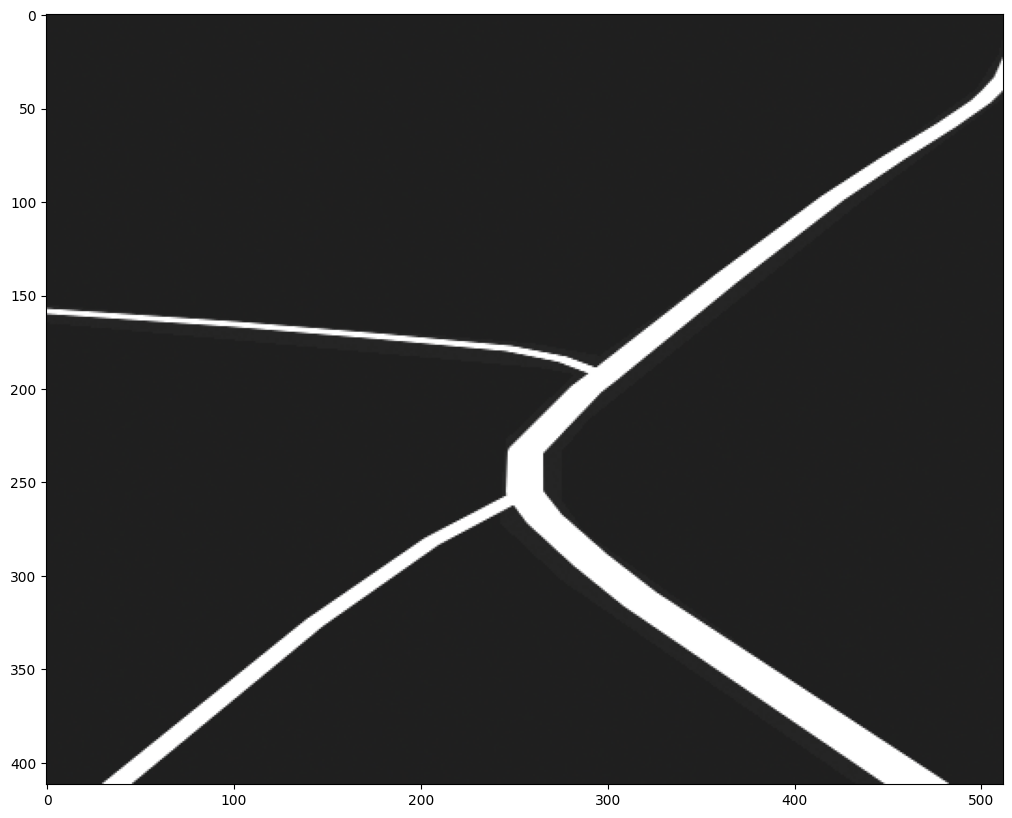

Binary thresholding


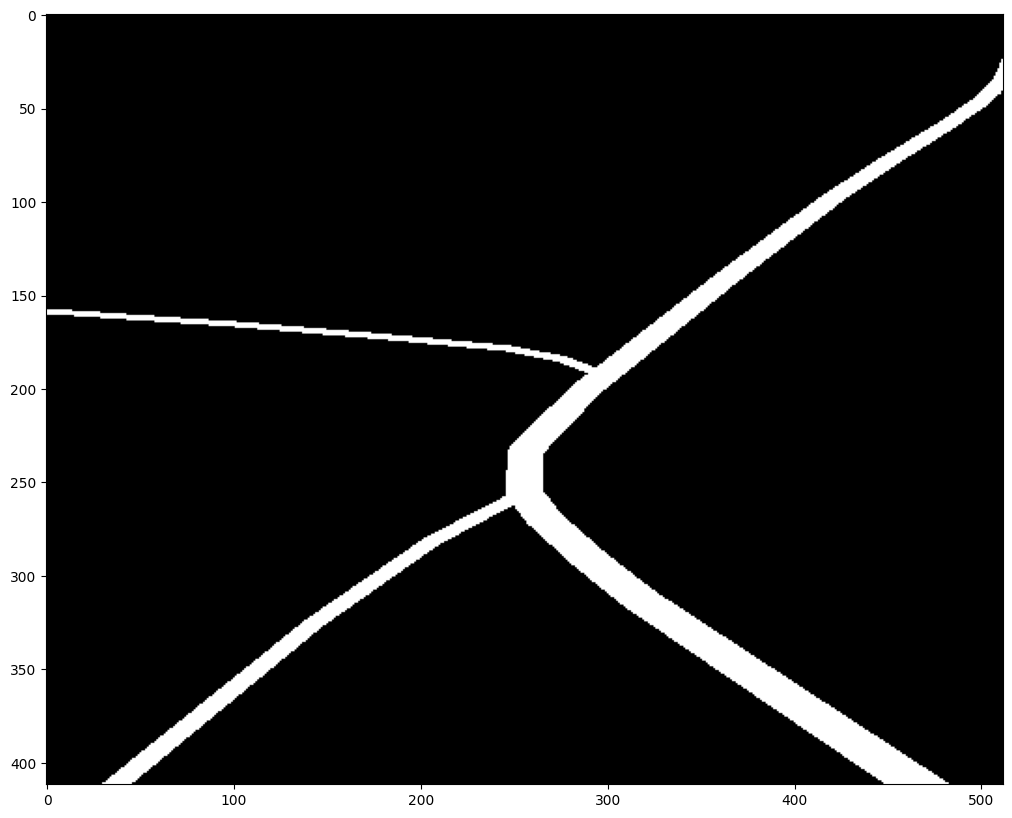

Getting intersections in skeleton (more than 2 neighbours)
2 intersections found in the skeleton:
[(194, 294), (253, 256)]


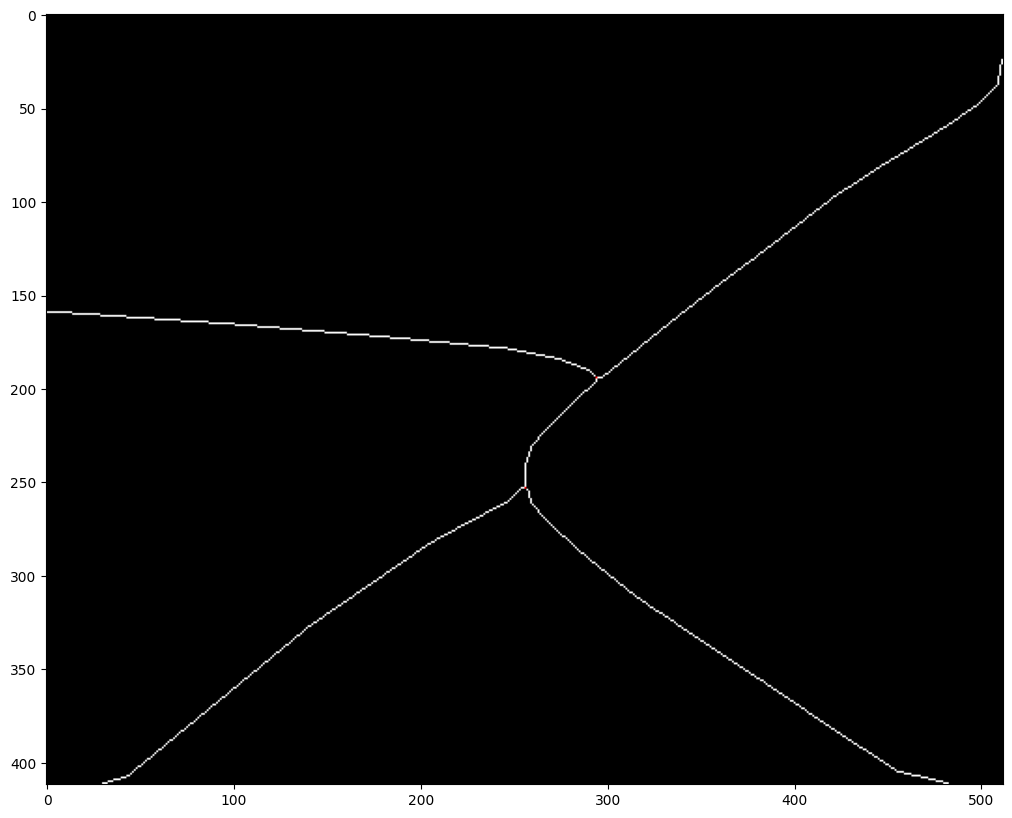

There are intersections in mapbox image 50.7631006_3.5486225.jpg


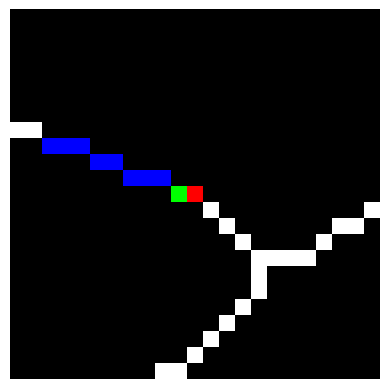

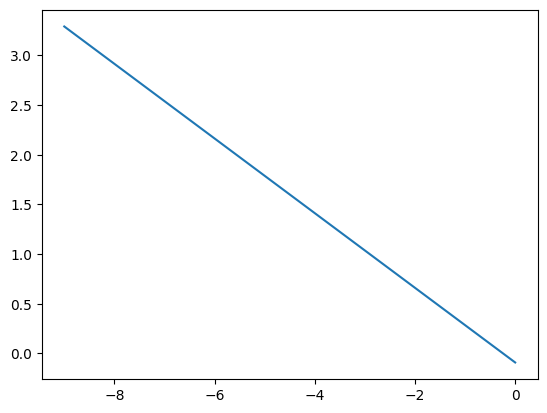

Angle is: 159.40590977969123


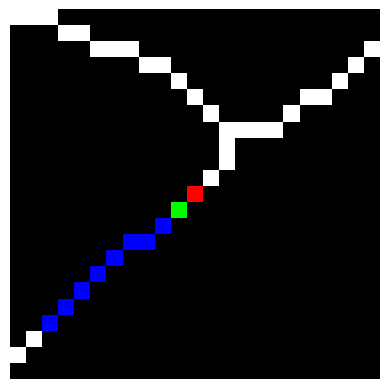

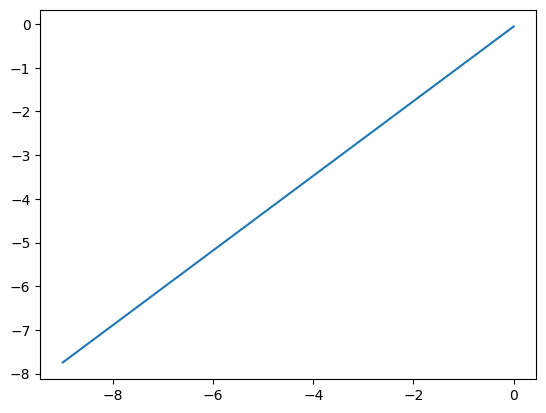

Angle is: 220.51539399045538


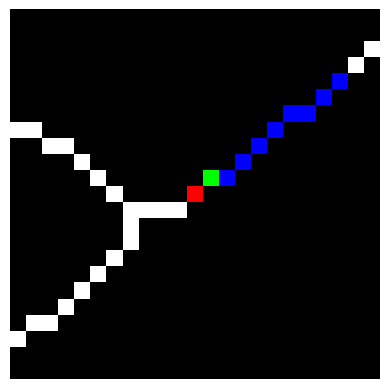

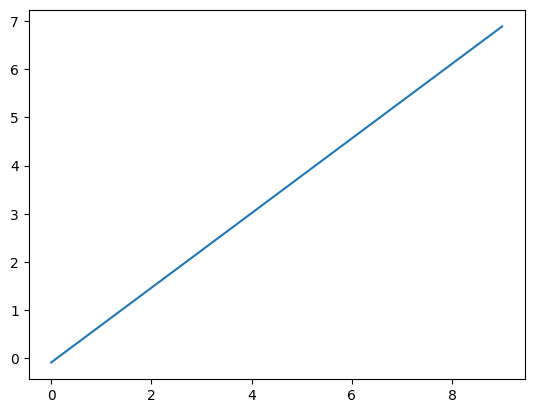

Angle is: 37.802792450938526


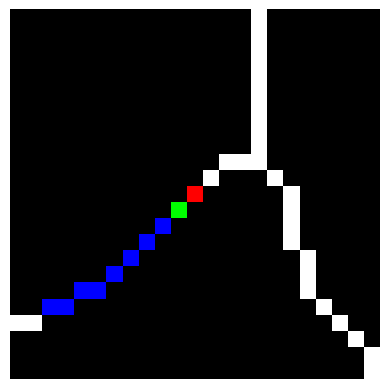

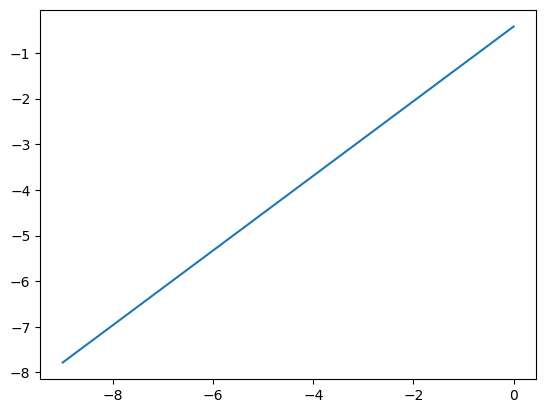

Angle is: 219.28940686250036


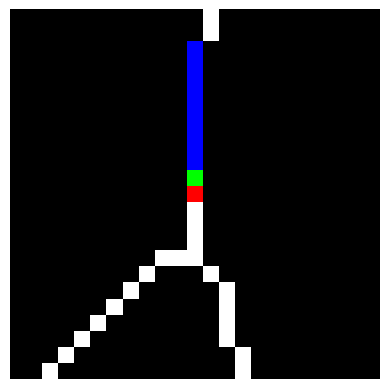

All x-values are the same
Angle is: 90


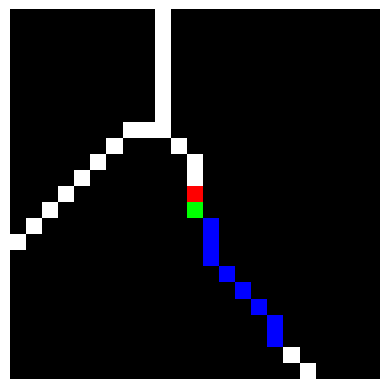

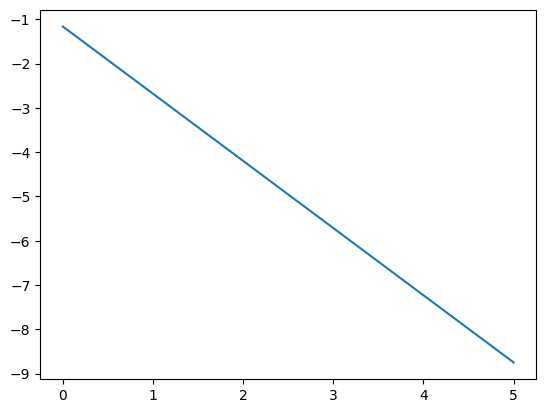

Angle is: 303.37783203643045
Descriptors: [[37.802792450938526, 159.40590977969123, 220.51539399045538], [90, 219.28940686250036, 303.37783203643045]] for mapbox image 50.7631006_3.5486225.jpg


In [13]:
visualize = True
seconds_passed = 453
mapbox_imgs_dir_path =  f"/Users/senneloobuyck/Documents/Thesis_project/04_matching/mapbox_method/mapbox_images_for_frame_{str(seconds_passed)}_RVV1"
mb_image = "50.7631006_3.5486225.jpg"
mb_image_path = os.path.join(mapbox_imgs_dir_path, mb_image)


des = find_descriptors_in_mapbox_image(mb_image_path, mb_image, vis=visualize)
print(f"Descriptors: {des} for mapbox image {mb_image}")